https://www.datacamp.com/community/tutorials/seaborn-python-tutorial#scale

https://seaborn.pydata.org/tutorial/aesthetics.html

# Occupancy Identification Using Machine Learning

Introduction to the data:
   1. Data was collected from 15th March 2020 to 28th March 2020 for every 10 minutes. Data has been preprocessed and stored in csv file for easy use.
   2. Data features are Temperature, Humidity, CO2, Light, HumidityRatio and Occupancy. 
   3. No Missing Value can be found as continuous data was taken from all sensors.

## Lets Import Library

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import shuffle 
import qgrid

%matplotlib inline

In [2]:
data=pd.read_csv(r'C:\Users\jpravijo\Desktop\Anaconda\occupancy_dataset.csv',index_col=0)

Qgrid allows you to explore your DataFrames with intuitive scrolling, sorting, and filtering controls, as well as edit your DataFrames by double clicking cells

In [3]:
qgrid.show_grid(data, show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
# We need to drop the date column as it holds no meaning in machine learning
data.drop('date',axis=1, inplace=True)

# It is good to shuffle the data now. We can use Shuffle from Sklearn
data=shuffle(data).set_index('Temperature').reset_index()

## Lets Start EDA 

In [5]:
data.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,21.29,25.20,0.0,450.000000,0.003942,0
1,20.00,25.00,0.0,441.666667,0.003610,0
2,20.20,18.89,0.0,443.000000,0.002758,0
3,20.50,33.70,0.0,692.500000,0.005030,0
4,20.50,19.89,0.0,441.000000,0.002959,0


In [6]:
data.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000
mean,20.817719,25.638326,137.261133,633.680988,0.003902,0.249421
std,1.075054,4.955395,211.561160,312.659270,0.000803,0.432698
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.000000,21.390000,0.000000,441.000000,0.003323,0.000000
50%,20.700000,25.666667,0.000000,464.000000,0.003804,0.000000
75%,21.500000,28.330000,413.000000,759.000000,0.004371,0.000000
max,24.260000,39.117500,1697.250000,2028.500000,0.006476,1.000000


First Step is to plot pairplot from seaborn to get clear idea of the dataset

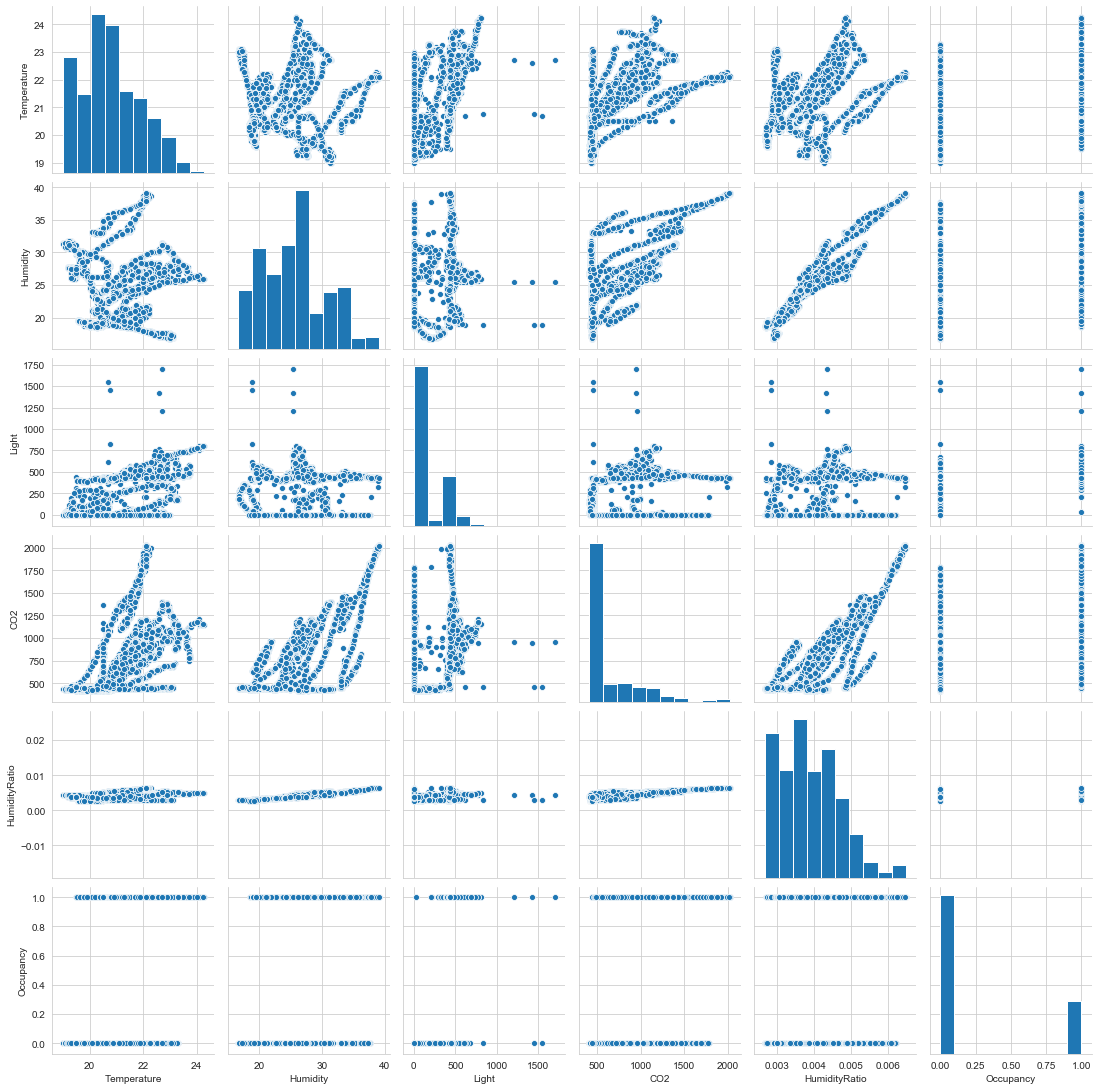

In [7]:
sns.set_style("whitegrid")
sns.pairplot(data=data)

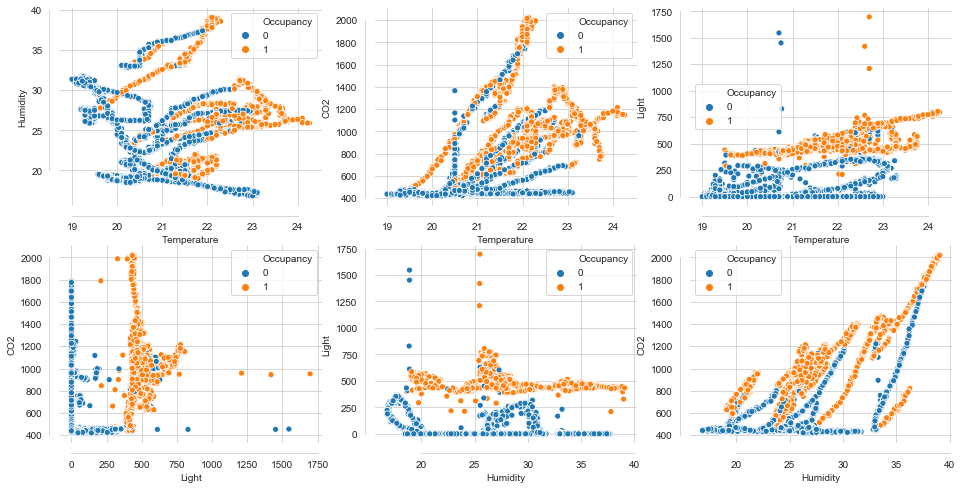

In [8]:
fig, ax = plt.subplots(2,3,figsize=(16,8))
sns.scatterplot(data=data, x='Temperature', y='Humidity', hue='Occupancy',ax=ax[0,0])
sns.scatterplot(data=data, x='Temperature', y='CO2', hue='Occupancy',ax=ax[0,1])
sns.scatterplot(data=data, x='Temperature', y='Light', hue='Occupancy',ax=ax[0,2])
sns.scatterplot(data=data, x='Light', y='CO2', hue='Occupancy',ax=ax[1,0])
sns.scatterplot(data=data, x='Humidity', y='Light', hue='Occupancy',ax=ax[1,1])
sns.scatterplot(data=data, x='Humidity', y='CO2', hue='Occupancy',ax=ax[1,2])

sns.despine(offset=10, trim=True);

In [9]:
X=data.drop('Occupancy', axis=1)
y=data['Occupancy']

## Lets split the data into Train and Test

In [15]:
X_train, X_test, Y_train, Y_test=train_test_split(X, y,test_size=0.2,random_state=0)
print(X_train.shape, X_test.shape)

(8640, 5) (2161, 5)


1. Inputs should be standardized before running any algorithms onto it \n
2. For standardizing the features we can use MinMaxScaler or StandardScaler but the preferred one is StandardScaler


## Lets standardize the data

In [16]:
ss=StandardScaler()
ss.fit(X_train)
print(f'mean={ss.mean_},\n var={ss.var_}')

mean=[2.08210275e+01 2.56537242e+01 1.38212728e+02 6.34717145e+02
 3.90581689e-03],
 var=[1.16243127e+00 2.43991946e+01 4.51406200e+04 9.72565302e+04
 6.41693468e-07]


In [17]:
X_train=ss.transform(X_train)
X_test=ss.transform(X_test)

## Lets use GridSearchCV to find the best estimator and its parameters

In [13]:
def gridsearcher(estimator, parameters, X_train, Y_train):
    clf=GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'f1', cv=10)
    clf.fit(X_train, Y_train)
    return clf.best_params_, clf.best_estimator_, clf.cv_results_, clf.best_score_

In [19]:
all_estimator=[
               LogisticRegression(), 
               SVC(),
               KNeighborsClassifier()
              ]
all_parameters=[
                {'C':[0.01,0.1,0.3, 0.5, 1,10,100],'solver':['newton-cg', 'lbfgs', 'liblinear']},
                {'C':[0.1, 1, 10, 20, 30 ,100],'kernel':['linear', 'rbf']},
                {'n_neighbors':[25,50,75,100,125,150], 'metric':['minkowski', 'euclidean']}
               ]
for estimator, parameters in zip(all_estimator, all_parameters):
    best_params, best_estimator, score, best_score = gridsearcher(estimator, parameters, X_train, Y_train)
    print(f' Best Parameters = {best_params}, \n Best Estimator = {best_estimator}, \n Best_score= {best_score} \n')
    #for mean_score, params in zip(score['mean_test_score'], score['params']):
        #print(mean_score, params)

 Best Parameters = {'C': 0.1, 'solver': 'liblinear'}, 
 Best Estimator = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 
 Best_score= 0.9703537097621334 

 Best Parameters = {'C': 1, 'kernel': 'rbf'}, 
 Best Estimator = SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 
 Best_score= 0.9717113057798861 

 Best Parameters = {'metric': 'minkowski', 'n_neighbors': 25}, 
 Best Estimator = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_n

The score contains the mean score of the each of the possibilities. C=0.1 and Solver = newton-cg provides high score as seen below

## Lets plot learning curve eventhough we got good score

In [48]:
def learning_curves(X, y, array, estimator=LogisticRegression(), cv=5):
    X_sizes, X_train_score, X_Validation_Score = learning_curve(estimator=estimator, X=X, y=y, cv=cv, train_sizes=array, scoring='f1')
    X_train_score=np.mean(X_train_score, axis=1)
    X_validation_score=np.mean(X_Validation_Score, axis=1)
    return X_sizes, X_train_score, X_validation_score
m=[100, 1000, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000]
X_sizes, X_train_score, X_validation_score= learning_curves(X_train, Y_train, m, cv=10)

Text(0, 0.5, 'Test/Validation Score')

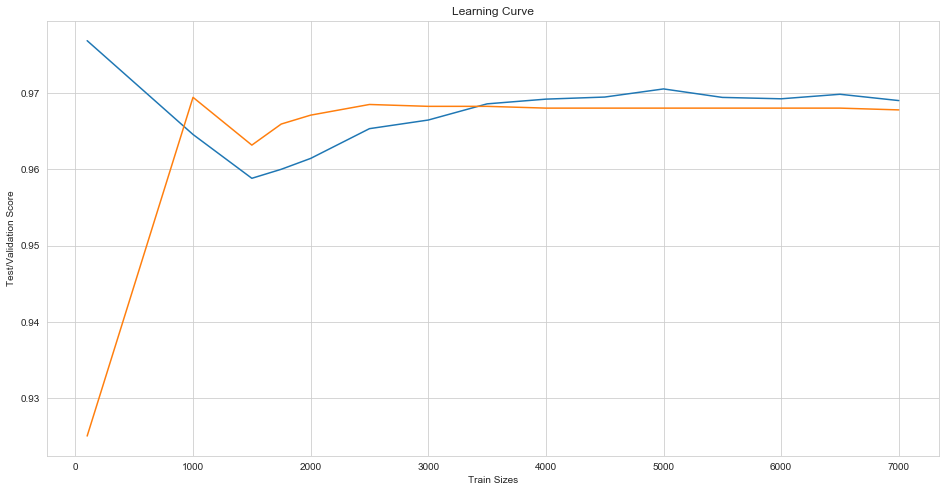

In [49]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(X_sizes, X_train_score)
ax.plot(X_sizes, X_validation_score)
ax.set_title('Learning Curve')
ax.set_xlabel('Train Sizes')
ax.set_ylabel('Test/Validation Score')

## Lets start the training and predicting process as Learning Curve looks good

We can take the best parameters from the gridsearchCV and use them to predict the final output.

### Lets start using SVC

In [58]:
svm=SVC(C=1, kernel= 'rbf')
svm.fit(X_train, Y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [59]:
predict=svm.predict(X_test)

In [62]:
print(f'f1_score = {f1_score(Y_test,predict)}\n')
print(f'accuracy = {svm.score(X_test,Y_test)}\n')
pd.crosstab(predict, Y_test)

f1_score = 0.9815157116451017

accuracy = 0.99074502545118



Occupancy,0,1
row_0,,
0,1610,2
1,18,531


### Lets use Logistic Regression now

In [63]:
log_reg = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
log_reg.fit(X_train, Y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
predict=log_reg.predict(X_test)

In [65]:
print(f'f1_score = {f1_score(Y_test,predict)}\n')
print(f'accuracy = {log_reg.score(X_test,Y_test)}\n')
pd.crosstab(predict, Y_test)

f1_score = 0.9805735430157262

accuracy = 0.990282276723739



Occupancy,0,1
row_0,,
0,1610,3
1,18,530


### Lets use KNN atlast

In [66]:
knn=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [ ]:
predict=knn.predict(X_test)

In [ ]:
print(f'f1_score = {f1_score(Y_test,predict)}\n')
print(f'accuracy = {knn.score(X_test,Y_test)}\n')
pd.crosstab(predict, Y_test)